**Interpolate Velocity Data using IDW method**

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Data Set**

In [2]:
# unstructured triangular grid
data_grid = pd.read_csv('grid_point.csv')
data_triangle = pd.read_csv('grid_triangle.csv', header=None)

# velocity data
data_velocity = pd.read_csv('velocity.csv')

In [3]:
# interpolation point (point with unknown velocity value)
data_grid

,x,y
0,225148.814,9029192.73
1,225660.142,9027270.93
2,226171.470,9025349.14
3,226682.798,9023427.35
4,227349.312,9021568.25
...,...,...
9011,221019.466,9096495.08
9012,220913.300,9096391.60
9013,220885.907,9096302.04
9014,212088.702,9094385.80


In [4]:
# velocity data (point with known velocity value)
data_velocity

,x,y,u,v,mag
0,225879.271,9028719.577,0.01244,-0.00326,0.01286
1,225701.319,9028170.220,0.00171,0.00045,0.00176
2,226382.362,9027334.827,0.00915,0.00577,0.01082
3,226341.186,9026435.540,0.00236,0.00063,0.00244
4,227037.621,9025756.450,0.00981,0.00376,0.01051
...,...,...,...,...,...
16961,212243.490,9094368.863,0.05598,0.13691,0.14791
16962,212230.661,9094483.533,0.07873,0.13128,0.15308
16963,212096.252,9094274.840,0.07563,0.10589,0.13013
16964,220972.824,9096398.790,0.00239,0.01314,0.01335


**Visualize the Data**

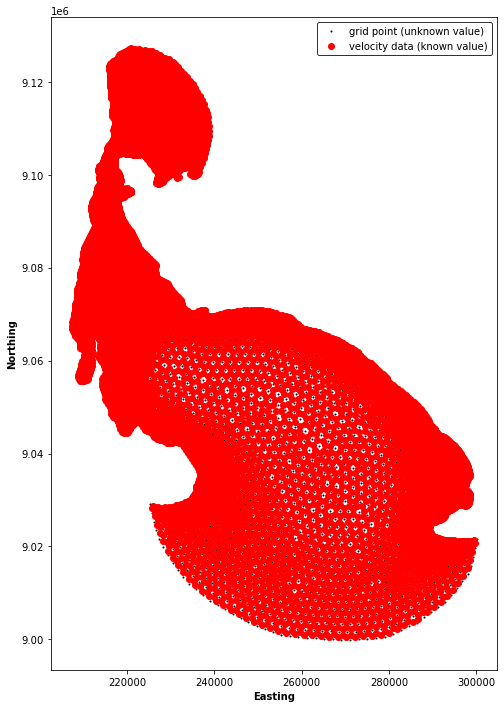

In [7]:
fig, ax = plt.subplots(figsize=(8,12))

# unstructured triangular grid
ax.plot(data_grid['x'], data_grid['y'], 'ko', markersize=1, label='grid point (unknown value)')

# velocity data
ax.plot(data_velocity['x'], data_velocity['y'], 'ro', label='velocity data (known value)')

ax.set_xlabel('Easting', fontweight='bold')
ax.set_ylabel('Northing', fontweight='bold')

ax.legend(edgecolor='black', facecolor='white')

plt.show()

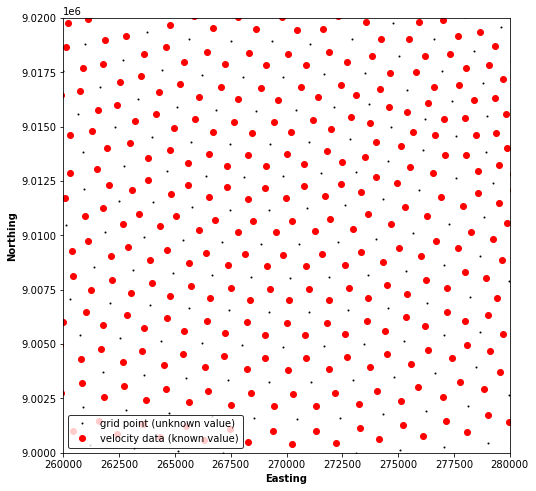

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

# unstructured triangular grid
ax.plot(data_grid['x'], data_grid['y'], 'ko', markersize=1, label='grid point (unknown value)')

# velocity data
ax.plot(data_velocity['x'], data_velocity['y'], 'ro', label='velocity data (known value)')

ax.set_xlim(260000, 280000)
ax.set_ylim(9000000, 9020000)

ax.set_xlabel('Easting', fontweight='bold')
ax.set_ylabel('Northing', fontweight='bold')

ax.legend(edgecolor='black', facecolor='white')

plt.show()

**Inverse Distance Weighting (IDW)**

In [9]:
# function: calculate a distance between two points
def distance(x1, x2, y2, y1):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [ ]:
# list of velocity from IDW
vIDW = []

for i in range(len(data_grid)):
    
    #=========get the distance: the closest 5 points=========#
    
    nPoints = 5 # number of points
    dList = []
    
    for j in range(len(data_velocity)):
        dList.append(distance(data_grid['x'][i], 
                              data_velocity['x'][j],
                              data_grid['y'][i], 
                              data_velocity['y'][j])) 
        
    dListDF = pd.Series(dList)
    dListDF.sort_values(ascending=True, inplace=True)
    dListDF = dListDF[0:nPoints]
    
    #=========check the distance=========#
    
    if dListDF.iloc[0] <= 1: # if the distance from interpolation point less than equal to 1 meter
        
        vIDW.append(data_velocity['mag'][dListDF.index.values[0]])
        
    else:    
    #=========IDW=========#    
        
        # get the velocity data: the closest 5 data
        
        vMag = []
        for idx in dListDF.index.values:
            vMag.append(data_velocity['mag'][idx])
        vMag = np.array(vMag)

        # weight calculation
        
        p = 2                     # power parameter
        wList = []
        for d in dListDF:
            wList.append(1/d**p) 
        wList = np.array(wList)

        # IDW
        
        vIDW.append(np.dot(vMag,np.transpose(wList))/np.sum(wList)) 

# final result
vIDW = np.array(vIDW)

**Step 1: distance calculation**

In [35]:
i = 0 # 
nPoints = 5 # number of points
dList = []

for j in range(len(data_velocity)):
    dList.append(distance(data_grid['x'][i], 
                          data_velocity['x'][j],
                          data_grid['y'][i], 
                          data_velocity['y'][j])) 

dListDF = pd.Series(dList)
dListDF.sort_values(ascending=True, inplace=True)
dListDF = dListDF[0:nPoints]

In [36]:
dListDF

0       870.310973
1      1162.234260
183    1420.193109
184    1837.857304
377    2104.072921
dtype: float64

In [37]:
data_grid.head()

,x,y
0,225148.814,9029192.73
1,225660.142,9027270.93
2,226171.470,9025349.14
3,226682.798,9023427.35
4,227349.312,9021568.25


In [38]:
data_velocity.iloc[dListDF.index.values]

,x,y,u,v,mag
0,225879.271,9028719.577,0.01244,-0.00326,0.01286
1,225701.319,9028170.220,0.00171,0.00045,0.00176
183,226433.667,9028587.667,-0.00369,0.00073,0.00376
184,226742.364,9028277.133,0.00689,0.00297,0.00750
377,227132.910,9028492.383,-0.00018,0.00003,0.00019


**Step 2: Check the closest distance**

In [32]:
if dListDF.iloc[0] <= 1: # if the distance from interpolation point less than equal to 1 meter

    data_velocity['mag'][dListDF.index.values[0]]
    print(True)

else:
    
    print(False)

False


**Step 3: Perform the IDW**

In [39]:
#=========IDW=========#    

# get the velocity data: the closest 5 data

vMag = []
for idx in dListDF.index.values:
    vMag.append(data_velocity['mag'][idx])
vMag = np.array(vMag)

# weight calculation

p = 2                     # power parameter
wList = []
for d in dListDF:
    wList.append(1/d**p) 
wList = np.array(wList)

# IDW

np.dot(vMag,np.transpose(wList))/np.sum(wList)

0.007279622149862976

**Step 4: save the result to numpy array**

In [ ]:
np.savetxt('velocity_IDW.csv', vIDW)

**Contour Fill Plot**

In [40]:
import matplotlib.tri as mtri

In [41]:
vIDW = np.loadtxt('velocity_IDW.csv')

In [42]:
triang = mtri.Triangulation(data_grid['x'], data_grid['y'], triangles=data_triangle-1)

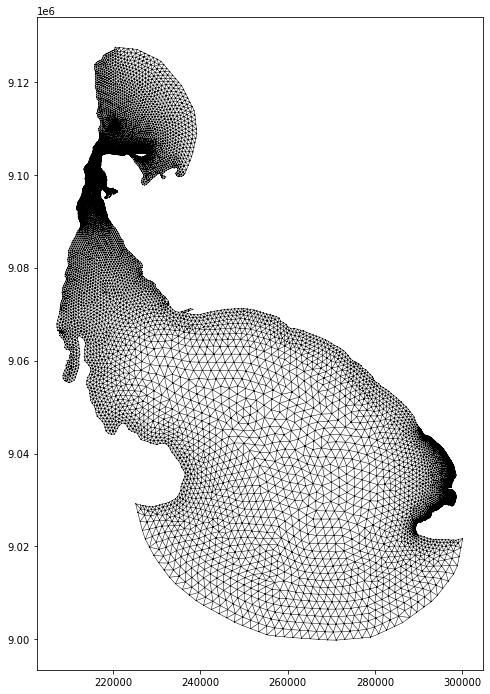

In [43]:
fig, ax = plt.subplots(figsize=(8,12))

ax.triplot(triang, color='black', linewidth=0.5)

plt.show()

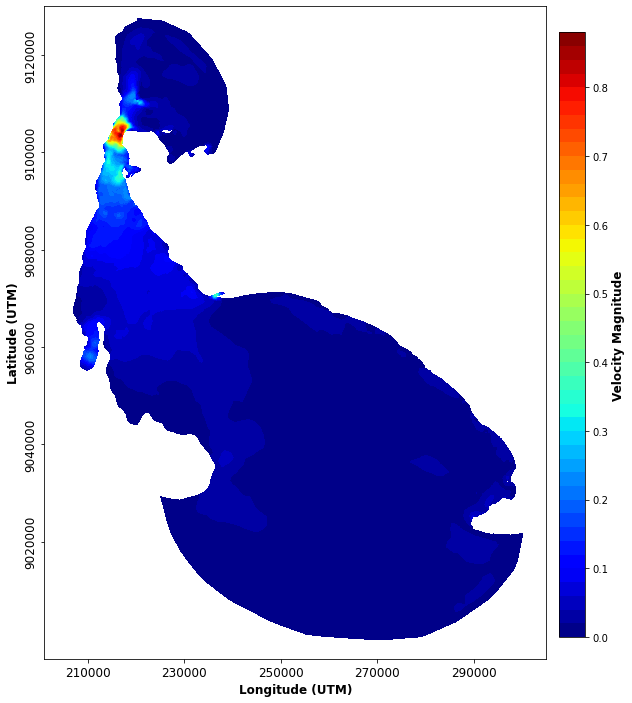

In [44]:
fig, ax = plt.subplots(figsize=(9,12))

# draw the contour fill
im = ax.tricontourf(triang, vIDW, cmap='jet', levels=50)

# adding the x and y axis labels
ax.set_ylabel('Latitude (UTM)', fontweight='bold', fontsize=12)
ax.set_xlabel('Longitude (UTM)', fontweight='bold', fontsize=12)

# set the x and y ticks
ax.set_yticks(ticks=[9020000, 9040000, 9060000, 9080000, 9100000, 9120000])
ax.set_xticks(ticks=[210000, 230000, 250000, 270000, 290000])

# rotate the yticks label and change the fontsize
ax.set_yticklabels(ax.get_yticks(), rotation=90, fontsize=12, va='center')
ax.set_xticklabels(ax.get_xticks(), fontsize=12, ha='center')

# set the plot axis limit
ax.set_xlim(201000, 305000)
ax.set_ylim(8995900, 9130000)

# colorbar position
cax = fig.add_axes([0.92, 0.15, 0.04, 0.7])

# adding colorbar and customize the colorbar
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
#cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical', fontsize=12, va='center')
cbar.ax.set_ylabel('Velocity Magnitude', fontweight='bold', fontsize=12)

# save the figure
#fig.savefig('/content/drive/MyDrive/Youtube Tutorial/Matplotlib Tutorial/#1 plot unstructured grid/002_TricontourPlot/contourfill.png',dpi=150, bbox_inches='tight')

plt.show()

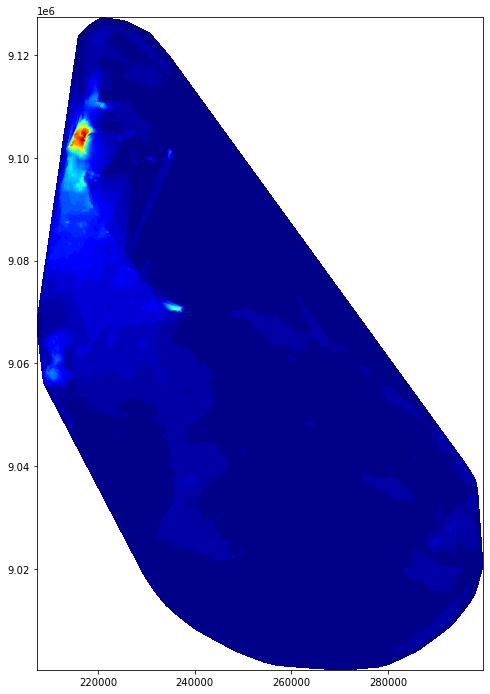

In [45]:
fig, ax = plt.subplots(figsize=(8,12))

ax.tricontourf(data_velocity['x'], data_velocity['y'], data_velocity['mag'], cmap='jet', levels=50)

plt.show()

**Thank you**